# Baseline 4b cut optimization

**Goal:** We saw a 25% improvement switching to the new b-taggers, and Caterina said she'd buy me dinner if we got to 40%.

So the questions that I'm trying to answer in this nb are:
1. For the baseline analysis, are the other cuts really necessary, and how much would we gain by removing them?
2. Is cateogorizing in $|\Delta \eta_{hh}|$ or $|\cos \Theta^*|$ going to be better?

Since Beojean hasn't shown detailed comparisons of *which* pairing alg is better, and I've done more comparisons w/ MDR + min $D_{hh}$, I'm going to use this as the baseline for these studies.

However, I could always make the pairing alg configurable so I can run this nb 2x and get all the plots.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import itertools

import uproot

import os
os.sys.path.append('../code')
from AnalysisUtils import nanoToDf, getExpectedBand, getBkgSysBand
from AnalysisUtils import getLambdaWeights, hackHistogram #, getNN
from plotting import sig_bkg_massplanes, plot_MDpT, plot2dSig, plotSigBkg
from analysis import read_tsv

os.sys.path.append('../eda_tools')
from NN_RW import getNNweights

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

## Step 1: Load in SM NR and ensure the analysis cuts can be applied manually 

In [2]:
fDir = "../../hh4b/hh4b-resolved-reconstruction" 

lumi15 = 3.2195
lumi16 = 24.5556
lumi = lumi15+lumi16

sdf = nanoToDf(f"{fDir}/sm_mdr_dl1r_77.root",ttree="afterPairing")
bdf = nanoToDf(f"{fDir}/data16_mdr_dl1r_77.root",ttree="afterPairing")


afterPairing
afterPairing


**Plan:** Add flags `MDpT`,`deta_hh_cut`,`Xwt_cut`

It might be worthwhile to try to make these ...

In [3]:
sdf.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets', 'valid',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh', 'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1',
       'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2', 'pT_h1_j2',
       'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2', 'angle_h1_j2',
       'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1',
       'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2', 'pT_h2_j2',
       'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'quantile_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2'],
      dtype='object')

In [4]:
for df in [sdf,bdf]:
    
    df['lead_HC_pt'] = np.where(df['pT_h1']>df['pT_h2'], df['pT_h1'], df['pT_h2'])
    df['subl_HC_pt'] = np.where(df['pT_h1']>df['pT_h2'], df['pT_h2'], df['pT_h1'])

    lead_pT_cut = 0.513333  * df.m_hh - 103.3333
    subl_pT_cut = 0.33333 * df.m_hh -  73.3333

    df['MDpT'] = (df.lead_HC_pt > lead_pT_cut) & (df.subl_HC_pt > subl_pT_cut) 

    # deta 
    df['deta_hh'] = np.abs(df.eta_h1 - df.eta_h2) 
    df['cut_deta_hh'] = (df.deta_hh < 1.5) 

    # Xwt
    df['cut_Xwt'] = (df.X_wt > 1.5) 

In [5]:
colsCutflow = ['Initial','Selected','Ntuple','Trigger','4 good jets $\geq$ 2 tagged',
              'X tagged', '$\Delta R_{jj}$', '$p_T(h)s$','$\Delta \eta_{hh}$',
              'Muon LepTop','Electron LepTop','HadTop','Multijet Enriched',
              '$X_{wt}$','Signal Region','Validation Region','Control Region']

cutflow = pd.DataFrame(0,colsCutflow,['resolved recon','my implementation'])

rr = uproot.open(f"{fDir}/sm_mdr_dl1r_77.root")
cutflow['resolved recon'] = rr['FourTagCutflow;1'].values

In [6]:
np.sum(sdf.loc[sdf.ntag>=4,'mc_sf'])

0.5489563250446302

Since the cuts up to MDR are taken from RR, just copy over those columns for these intials selections. 

In [7]:
cutflow.loc[colsCutflow[:6],'my implementation'] = cutflow.loc[colsCutflow[:6],'resolved recon']

Now put in my cuts!

In [8]:
mask = (sdf.ntag>=4) 
cutflow.loc['$\Delta R_{jj}$','my implementation'] = np.sum(sdf.loc[mask,'mc_sf'])

mask = mask & sdf['MDpT']
cutflow.loc['$p_T(h)s$','my implementation'] = np.sum(sdf.loc[mask,'mc_sf'])

mask = mask & sdf['cut_deta_hh']
cutflow.loc['$\Delta \eta_{hh}$','my implementation'] = np.sum(sdf.loc[mask,'mc_sf'])

mask = mask & sdf['cut_Xwt']
cutflow.loc['$X_{wt}$','my implementation'] = np.sum(sdf.loc[mask,'mc_sf'])

# SR, VR, CR
for r,col in enumerate(['Signal Region','Validation Region','Control Region']):
    cutflow.loc[col,'my implementation'] = \
        np.sum(sdf.loc[mask&(sdf.kinematic_region==r),'mc_sf'])

In [9]:
cf_cols = ['Initial','Selected','Ntuple','Trigger','4 good jets $\geq$ 2 tagged',
            'X tagged', '$\Delta R_{jj}$', '$p_T(h)s$','$\Delta \eta_{hh}$',
            '$X_{wt}$','Signal Region','Validation Region','Control Region']
cutflow.loc[cf_cols,['resolved recon','my implementation']].round(4)

resolved recon  my implementation
Initial                          26458.6274         26458.6274
Selected                         26458.6274         26458.6274
Ntuple                               7.0645             7.0645
Trigger                              4.2629             4.2629
4 good jets $\geq$ 2 tagged          3.2780             3.2780
X tagged                             0.6121             0.6121
$\Delta R_{jj}$                      0.5490             0.5490
$p_T(h)s$                            0.5177             0.5177
$\Delta \eta_{hh}$                   0.4726             0.4726
$X_{wt}$                             0.4315             0.4315
Signal Region                        0.2282             0.2282
Validation Region                    0.1145             0.1145
Control Region                       0.0547             0.0547

Ok, I've *passed the cutflow challenge*!!!

## Step 2: Train Sean's NN reweighting

**Default options for Sean's training**

`./NN_RW.py -d data16.root -y 2016 --doLog pT_2 pT_4 dRjj_1 dRjj_2 pt_hh --bootstrap 100 --job $2 --n_jobs 10`

But, Lucas's `getNNweights` is very easy for me to use with my workflow, so I'm going to use it, and I double checked that I have the same architecture / hyperparameters as Sean's workflow (at least what's inside his `nn_reweighting` branch as of Feb $6^{th}$ 2020). 


In [10]:
# Nominal model after *all* of the cuts have been applied
bkg_Xwt = bdf.MDpT & bdf.cut_deta_hh & bdf.cut_Xwt

modelName = "models/data16_mdr_dl1r_77/afterPairing.h5"

getNNweights(bdf, kinematic_region = 2,epochs = 50,patience=10,
             train=False, key="w_2b_afterPairing",modelName=modelName)

Instructions for updating:
Colocations handled automatically by placer.
rw 2b yield 27700.08
4b yield 26923


As Rafael suggested, it's going to be the most honest to change *as few things as possible* between these two trainings, so let's make sure we always train after $X_{wt}$
1. After $\Delta \eta_{hh}$ cut
2. Before $\Delta \eta_{hh}$ cut

In [11]:
modelName = "models/data16_mdr_dl1r_77/baseline.h5"
mask = bdf.MDpT & bdf.cut_deta_hh & bdf.cut_Xwt

getNNweights(bdf, mask=mask,kinematic_region=2,
             epochs = 50,patience=10,train=False, 
             key="w_2b_baseline",modelName=modelName)

rw 2b yield 13657.609
4b yield 14498


In [12]:
mask = bdf.MDpT & bdf.cut_deta_hh & bdf.cut_Xwt

print(bdf.loc[mask&(bdf.kinematic_region==2)&(bdf.ntag==2),'w_2b_baseline'].sum())
print(bdf.loc[mask&(bdf.kinematic_region==2)&(bdf.ntag>=4),'mc_sf'].sum())

14498.002
14498.0


In [13]:
14260.385 / 26923

0.5296729562084463

In [14]:
modelName = "models/data16_mdr_dl1r_77/without_deta_hh.h5"
mask = bdf.MDpT & bdf.cut_Xwt

getNNweights(bdf, mask=mask, kinematic_region=2,
             epochs = 50,patience=10,train=False, 
             key="w_2b_no_deta",modelName=modelName)

rw 2b yield 17641.12
4b yield 17805


Ok, so since I have everything setup now to compare the limit on the SM between the algorithms, might as well just do it here!

In [15]:
# Load in the dfs for the bdt pairing
s_bdt = nanoToDf(f"{fDir}/bdt_dl1r_77.root",ttree="sig")

SeanDir = "../../public/hh4b/bTagOptStudies/SeansFiles/dl1r/77"
b_bdt = nanoToDf(f"{SeanDir}/data16_with_weights.root",ttree="fullmassplane")

sig
fullmassplane


In [16]:
# Normalize by the luminosity for the signal - just need to ensure that 
# you haven't done this before
if np.sum(sdf.loc[sdf.ntag>=4,'mc_sf']) < 1:
    print(f"Scaling to L = {lumi:.2f} ifb for baseline")
    sdf['mc_sf'] *= lumi
    
if np.sum(s_bdt.loc[s_bdt.ntag>=4,'mc_sf']) < 1:
    print(f"Scaling to L = {lumi:.2f} ifb for BDT pairing")
    s_bdt['mc_sf'] *= lumi

Scaling to L = 27.78 ifb for baseline
Scaling to L = 27.78 ifb for BDT pairing


For the sake of completeness, maybe I should also look at the cutflows?

In [17]:
text = '$\mathbf{ATLAS}$ Internal\n'
text += r'JAN20 MNT, DL1r 77% WP'

edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])
x = 0.5*(edges[:-1]+edges[1:])

In [18]:
labels = ['MDR+min($D_{hh}$)','BDT pairing']
yields = pd.DataFrame(0,index=['$s$','$b$','$s/\sqrt{b}$', '$s/b$'],columns=labels)

# The stats results
bidx = ['$-2\sigma$','$-\sigma$','exp','$+\sigma$', '$+2\sigma$']
mu_tests = np.linspace(1,50, 50)

stats = pd.DataFrame(0,index=bidx,columns=labels)
sys   = pd.DataFrame(0,index=bidx,columns=labels)

In [19]:
s_mdr = nanoToDf(f"{fDir}/sm_mdr_dl1r_77.root",ttree="sig")
s_mdr['mc_sf'] *= lumi

sig


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:184: RuntimeWarning: invalid value encountered in multiply
  return n * np.log(lam) - lam - gammaln(n + 1.0)


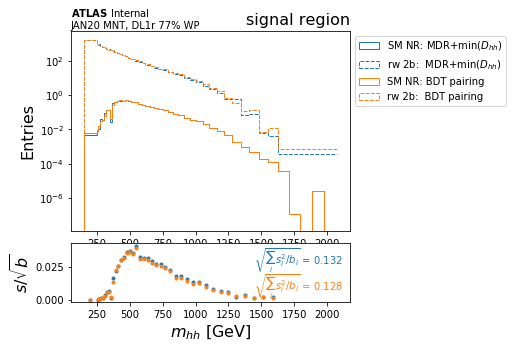

MDR+min($D_{hh}$)  BDT pairing
$s$                    6.337965     6.296366
$b$                 9618.196289  9216.658526
$s/\sqrt{b}$           0.064625     0.065585
$s/b$                  0.000659     0.000683

In [20]:
# Make the mhh histogram for the signal
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# Loop through the options (using the bdt pairing)
for s,b,w2b,label,color,ytxt in zip([sdf[sdf.MDpT & sdf.cut_deta_hh & sdf.cut_Xwt],s_bdt],
                                    [bdf[bdf.MDpT & bdf.cut_deta_hh & bdf.cut_Xwt],b_bdt],
                                    ['w_2b_baseline','w_2b'],
                                    labels,
                                    ['C0','C1'],[.95,.5]):

    # signal
    si,_,_ = ax1.hist(s.loc[(s.ntag>=4)&(s.kinematic_region==0),'m_hh'],
                     edges,color=color,histtype='step',log=True,
                     label="SM NR: "+label,ls='-',
                     weights=s.loc[(s.ntag>=4)&(s.kinematic_region==0),'mc_sf'])

    # background
    bi,_,_ = ax1.hist(b.loc[(b.ntag==2)&(b.kinematic_region==0),'m_hh'],
                     edges,color=color,histtype='step',log=True,
                     label="rw 2b:  "+label,ls='--',
                     weights=b.loc[(b.ntag==2)&(b.kinematic_region==0),w2b])

    # Significance (it probably would be a good idea to put mv2 and dl1r in different subpanels)
    ax2.plot(x[bi!=0],si[bi!=0]/np.sqrt(bi[bi!=0]),marker='.',color=color,linewidth=0)

    sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

    ax2.text(.975,ytxt,sigText+'{:.3f}'.format(np.sqrt(np.sum(si[bi!=0]**2 / bi[bi!=0]))),
             ha='right',va='top',#fontsize=8,
             transform=ax2.transAxes,color=color)

    yields.loc['$s$',label] = np.sum(si)
    yields.loc['$b$',label] = np.sum(bi)
    yields.loc['$s/b$',label] = np.sum(si) / np.sum(bi)
    yields.loc['$s/\sqrt{b}$',label] = np.sum(si) / np.sqrt(np.sum(bi))

    # Calculate the limit
    band = getExpectedBand(si,bi,mu_tests)
    stats.loc[bidx,label] = band
    
# Text per subfig
ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)

# Make the plot pretty
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=16)
ax1.set_ylabel('Entries', fontsize=16)
ax1.set_title('signal region', loc='right',fontsize=16)
ax1.legend(bbox_to_anchor=(1,1))

ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('figures/dl1r_77/m_hh_SR_mdr_vs_bdt.pdf',bbox_inches='tight')

plt.show()

# Compare the yields in the SR
yields

What increase in signal yield should we be expecting to see b/w switching WPs?

In [21]:
.77**4/(.7**4)

1.4641000000000004

Ok, this looser WP is a *good* increase in the signal efficiency compared to what I was looking at before.

The part that I really *don't* understand about this is why the BDT pairing has a *lower* signal efficinecy and a *higher* background rejection.

**Hypotheses:**
- I think the signal could have *lower* signal efficiency for the BDT pairing because of the differences between the SM and scalar signals
- I think since Beojean has never carefully studies what happens to the background, this could very well be that he's made the background sculpting worse and there are *more* events in the SR.

However, Sean and Max were both like, it doesn't matter, b/c it's like a 2% difference in background yield... which is a fair point.



Get the stats only limit

In [22]:
stats

MDR+min($D_{hh}$)  BDT pairing
$-2\sigma$           8.024449     8.332081
$-\sigma$           10.825654    11.186766
exp                 15.074463    15.598835
$+\sigma$           21.114851    21.817966
$+2\sigma$          28.544301    29.475031

Ok, so Max said he was 99.999999999% sure that the pairing alg wouldn't change further things, so I'm going to use this as justification to *move on* with this to investigate the other things I was trying to answer.

In [23]:
rr = uproot.open(f"{fDir}/bdt_dl1r_77.root")
cutflow['4b SM: MDR+$D_{hh}$'] = cutflow['resolved recon']
cutflow['4b SM: BDT'] = rr['FourTagCutflow;1'].values

In [24]:
cutflow[[f'4b SM: {l}' for l in ['MDR+$D_{hh}$','BDT']]]

4b SM: MDR+$D_{hh}$    4b SM: BDT
Initial                             26458.627423  26458.627423
Selected                            26458.627423  26458.627423
Ntuple                                  7.064455      7.064455
Trigger                                 4.262942      4.262942
4 good jets $\geq$ 2 tagged             3.278005      3.278005
X tagged                                0.612114      0.612114
$\Delta R_{jj}$                         0.548956      0.612114
$p_T(h)s$                               0.517744      0.532793
$\Delta \eta_{hh}$                      0.472597      0.483565
Muon LepTop                             0.000065      0.000066
Electron LepTop                         0.000491      0.000481
HadTop                                  0.011360      0.011048
Multijet Enriched                       0.461237      0.472518
$X_{wt}$                                0.431493      0.442661
Signal Region                           0.228189      0.226691
Validation Region                       0.114486      0.115338
Control Region                          0.054687      0.055491

Also include the 2b and 4b data on this plot, although I'm going to need to **change the 4-tagged index** to something like **X-tagged**

In [25]:
rr_mdr = uproot.open(f"{fDir}/data16_mdr_dl1r_77.root")
rr_bdt = uproot.open(f"{fDir}/data16_bdt_dl1r_77.root")

# 2b
cutflow['2b data 16: MDR+$D_{hh}$'] = rr_mdr['TwoTagCutflow'].values
cutflow['2b data 16: BDT'] = rr_bdt['TwoTagCutflow'].values

# 4b
cols4b = colsCutflow[:14]+colsCutflow[-2:]

cutflow.loc[cols4b,'4b data 16: MDR+$D_{hh}$'] = rr_mdr['FourTagCutflow'].values
cutflow.loc[cols4b,'4b data 16: BDT'] = rr_bdt['FourTagCutflow'].values

In [26]:
physSmpls = [f'4b SM: {l}' for l in ['MDR+$D_{hh}$','BDT']]
physSmpls += [f'{nb}b data 16: {l}' for nb in [2,4] for l in ['MDR+$D_{hh}$','BDT']]
cutflow.loc[cf_cols,physSmpls]

4b SM: MDR+$D_{hh}$    4b SM: BDT  \
Initial                             26458.627423  26458.627423   
Selected                            26458.627423  26458.627423   
Ntuple                                  7.064455      7.064455   
Trigger                                 4.262942      4.262942   
4 good jets $\geq$ 2 tagged             3.278005      3.278005   
X tagged                                0.612114      0.612114   
$\Delta R_{jj}$                         0.548956      0.612114   
$p_T(h)s$                               0.517744      0.532793   
$\Delta \eta_{hh}$                      0.472597      0.483565   
$X_{wt}$                                0.431493      0.442661   
Signal Region                           0.228189      0.226691   
Validation Region                       0.114486      0.115338   
Control Region                          0.054687      0.055491   

                             2b data 16: MDR+$D_{hh}$  2b data 16: BDT  \
Initial                                  5.123611e+09     5.123611e+09   
Selected                                 8.596592e+08     8.596592e+08   
Ntuple                                   1.120045e+08     1.120045e+08   
Trigger                                  6.499295e+07     6.499295e+07   
4 good jets $\geq$ 2 tagged              4.141126e+07     4.141126e+07   
X tagged                                 3.662030e+07     3.662030e+07   
$\Delta R_{jj}$                          1.287938e+07     3.662030e+07   
$p_T(h)s$                                1.087114e+07     1.457807e+07   
$\Delta \eta_{hh}$                       8.263925e+06     1.149567e+07   
$X_{wt}$                                 6.976848e+06     1.008608e+07   
Signal Region                            9.099270e+05     8.634760e+05   
Validation Region                        9.695380e+05     1.046982e+06   
Control Region                           1.331372e+06     1.560376e+06   

                             4b data 16: MDR+$D_{hh}$  4b data 16: BDT  
Initial                                  5.123611e+09     5.123611e+09  
Selected                                 8.596592e+08     8.596592e+08  
Ntuple                                   1.120045e+08     1.120045e+08  
Trigger                                  6.499295e+07     6.499295e+07  
4 good jets $\geq$ 2 tagged              4.141126e+07     4.141126e+07  
X tagged                                 3.393030e+05     3.393030e+05  
$\Delta R_{jj}$                          1.546000e+05     3.393030e+05  
$p_T(h)s$                                1.301480e+05     1.653370e+05  
$\Delta \eta_{hh}$                       9.847100e+04     1.288300e+05  
$X_{wt}$                                 6.823700e+04     9.694000e+04  
Signal Region                                     NaN              NaN  
Validation Region                        1.045500e+04     1.115200e+04  
Control Region                           1.449800e+04     1.688200e+04

In [27]:
VR,CR = 'Validation Region','Control Region'

No handles with labels found to put in legend.


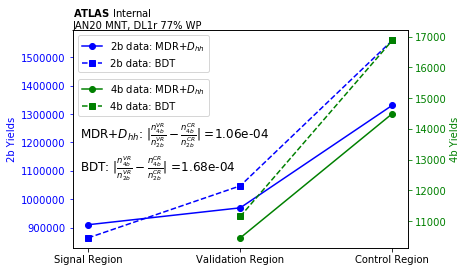

In [28]:
# 2b
x = [f'{s} Region' for s in ['Signal', 'Validation','Control']]
plt.plot(cutflow.loc[x,'2b data 16: MDR+$D_{hh}$'],color='b',
         marker='o',markersize=6,linestyle='-',
         label='2b data: MDR+$D_{hh}$')
plt.plot(cutflow.loc[x,'2b data 16: BDT'],color='b',
         marker='s',markersize=6,linestyle='--',
         label='2b data: BDT')

ax1 = plt.gca()
ax1.tick_params(axis='y', colors='b')
ax1.yaxis.label.set_color('b')
ax1.set_ylabel('2b Yields')
ax2.legend(loc='upper left')

ax2 = ax1.twinx()

# 4b
plt.plot(cutflow.loc[x,'4b data 16: MDR+$D_{hh}$'],color='g',
         marker='o',markersize=6,linestyle='-',
         label='4b data: MDR+$D_{hh}$')
plt.plot(cutflow.loc[x,'4b data 16: BDT'],color='g',
         marker='s',markersize=6,linestyle='--',
         label='4b data: BDT')

ax2.tick_params(axis='y', colors='g')
ax2.yaxis.label.set_color('g')
ax2.set_ylabel('4b Yields')

ax1.legend(loc='upper left')

ax2.legend(loc='upper left',bbox_to_anchor=(0,.8))

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)

'''
Add text about the difference b/w ratios
'''
ratioText = r'$| \frac{n_{4b}^{VR}}{n_{2b}^{VR}} - \frac{n_{4b}^{CR}}{n_{2b}^{CR}} |$ ='

alg = 'MDR+$D_{hh}$'
VR_ratio = cutflow.loc[VR, f'4b data 16: {alg}'] / cutflow.loc[VR, f'2b data 16: {alg}']
CR_ratio = cutflow.loc[CR, f'4b data 16: {alg}'] / cutflow.loc[CR, f'2b data 16: {alg}']
n = np.abs(VR_ratio-CR_ratio)  

plt.text(0.02, 0.45, alg + ": " + ratioText + f'{n:.2e}',
         ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)

ratioText = r'$| \frac{n_{4b}^{VR}}{n_{2b}^{VR}} - \frac{n_{4b}^{CR}}{n_{2b}^{CR}} |$ ='

alg = 'BDT'
VR_ratio = cutflow.loc[VR, f'4b data 16: {alg}'] / cutflow.loc[VR, f'2b data 16: {alg}']
CR_ratio = cutflow.loc[CR, f'4b data 16: {alg}'] / cutflow.loc[CR, f'2b data 16: {alg}']
n = np.abs(VR_ratio-CR_ratio)  
plt.text(0.02, 0.3, alg + ": " + ratioText + f'{n:.2e}',
         ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)

plt.savefig('figures/dl1r_77/yields_kr.pdf',bbox_inches='tight')

plt.show()

Rafael said this wasn't an issue as it just means that the shapes in the massplane is different.

What's a problem is if

$$| \frac{n_{4b,VR}}{n_{2b,VR}}(BDT) - \frac{n_{4b,CR}}{n_{2b,CR}}(BDT) |  >>  | \frac{n_{4b,VR}}{n_{2b,VR}}(D_{hh}) - \frac{n_{4b,CR}}{n_{2b,CR}}(D_{hh}) | $$

So that's why I added these #s to the plot as well, but I'm waiting for Rafael to tell me whether this is an issue or not.


I wonder if it's because by training on 4b signal, you've biased the analysis(?)

In [29]:
for alg in ['MDR+$D_{hh}$','BDT']:
    VR_ratio = cutflow.loc[VR, f'4b data 16: {alg}'] / cutflow.loc[VR, f'2b data 16: {alg}']
    CR_ratio = cutflow.loc[CR, f'4b data 16: {alg}'] / cutflow.loc[CR, f'2b data 16: {alg}']
    
    print(alg,VR_ratio,CR_ratio,np.abs(VR_ratio-CR_ratio))


MDR+$D_{hh}$ 0.010783486567829214 0.010889518481686561 0.00010603191385734692
BDT 0.010651568030777988 0.01081918717027178 0.0001676191394937923


## Step 3: Check the MD$p_T$ cut in the SR

In [30]:
smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += "4b SM NR mc16a JAN 2019 prod\n"
smText += 'DL1r 77% WP with MDR min($D_{hh}$)'

dataText = "$\mathbf{ATLAS}$ data Internal\n"
dataText += "2b 2016 data JAN 2019 prod\n"
dataText += "DL1r 77% WP with MDR min($D_{hh}$)" 

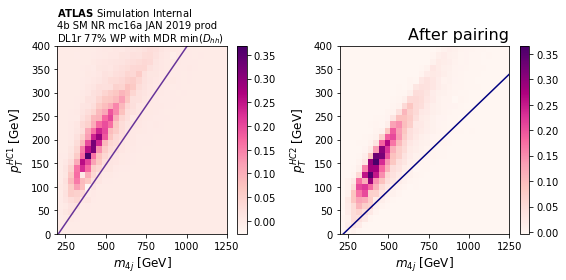

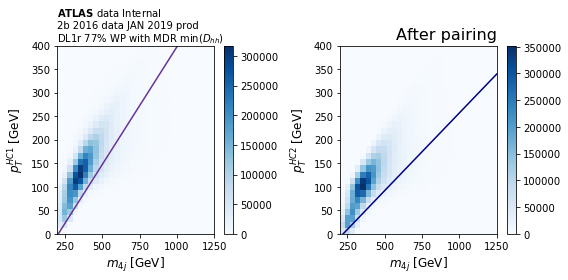

In [31]:
plot_MDpT(sdf[sdf.ntag>=4],cmap='RdPu',text=smText,title='After pairing')#,figDir=f'figures/{sigSubDir}') 
plot_MDpT(bdf[bdf.ntag==2],cmap='Blues',text=dataText,title='After pairing')#,figDir=f'figures/{bkgSubDir}') 

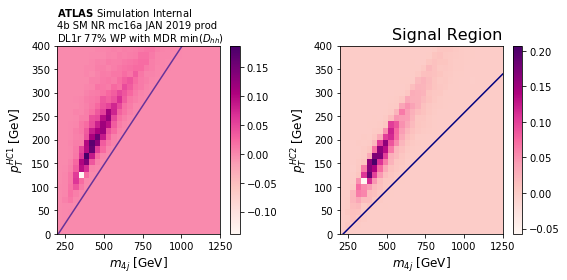

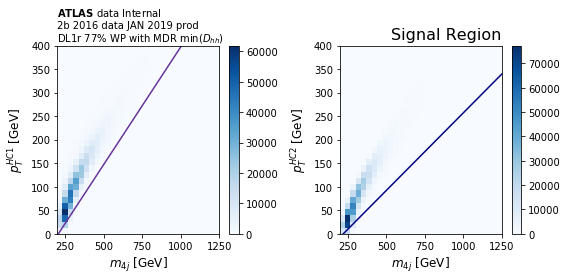

In [32]:
plot_MDpT(sdf[(sdf.ntag>=4)&(sdf.cut_deta_hh)&(sdf.cut_Xwt)&(sdf.kinematic_region==0)],
          cmap='RdPu',text=smText,title='Signal Region')#,figDir=f'figures/{sigSubDir}',tag='_SR') 

plot_MDpT(bdf[(bdf.ntag==2)&(bdf.cut_deta_hh)&(bdf.cut_Xwt)&(bdf.kinematic_region==0)],
          cmap='Blues',text=dataText,title='Signal Region')#,figDir=f'figures/{bkgSubDir}',tag='_SR') 

Oh, this is *super* cool to me that unlike pairAGraph, it seems like we could cut just a little harder and eliminate these low $m_{4j}$ events.

So I think we should wait to revisit this until the systematic is worked out, b/c cutting harder for low $m_{4j}$ could hurt our limit with the systematic.

But maybe I'll try to answer the categorization question first, and then iterate on this?

It doesn't seem like the message here is that we want to go looser (as it was w/ pairAGraph), it seems like we would want to go tighter, probably b/c we now have more background in the SR!

## Step 4: Compare categorizing in $\Delta \eta_{hh}$ vs $\cos \Theta^*$

Ok, I should be able to copy some code over from the `4b-Cut-Optimization` notebook.


**Step 1:** Can our background estimate derived *after* the $\Delta \eta_{hh}$ cut be applied before it?

To address this question, I should compare the rw variables and $m_{hh}$ in these two phase space regions.


In [44]:
rw_vars = ['njets','pT_4', 'pT_2', 'dRjj_1', 'dRjj_2','eta_i','pt_hh','m_hh']
nBins = [8]+[50]*7
myRanges = [(3.5,12.5),(0,125),(0,200),(0,4),(0,4),(0,2.5),(0,400),(0,1250)]

In [34]:
text = '$\mathbf{ATLAS}$ 2016 data Internal\n'
text += 'JAN 2020 MNT prod\n'
text += 'DL1r with MDR + min $D_{hh}$ pairing'

In [35]:
bdf.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets', 'valid',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'm_hh', 'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1',
       'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2', 'pT_h1_j2',
       'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2', 'angle_h1_j2',
       'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1', 'tag_h2_j1',
       'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2', 'pT_h2_j2',
       'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'quantile_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'lead_HC_pt', 'subl_HC_pt',
       'MDpT', 'deta_hh', 'cut_deta_hh', 'cut_Xwt', 'pT_4_log', 'pT_2_log',
       'dRjj_1_log', 'dRjj_2_log', 'pt_hh_log', 'w_2b_afterPairing',
       'w_2b_baseli

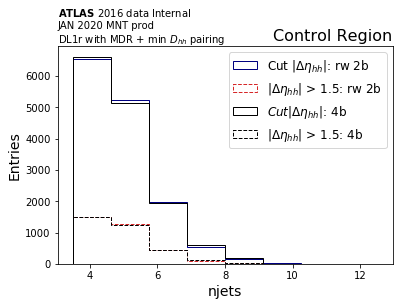

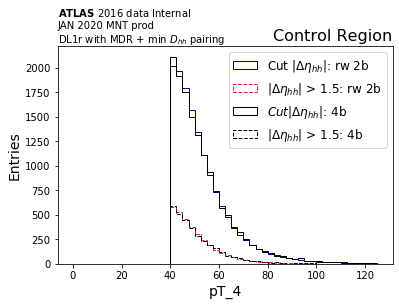

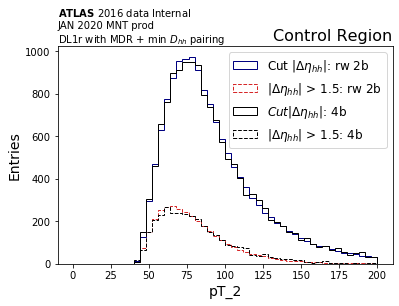

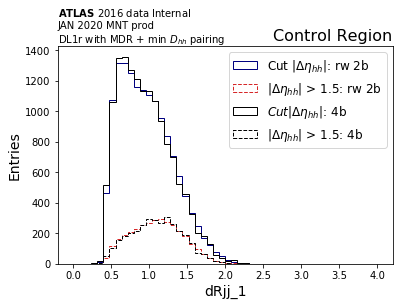

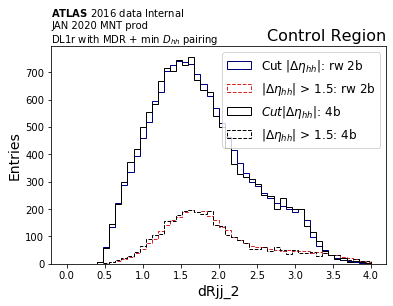

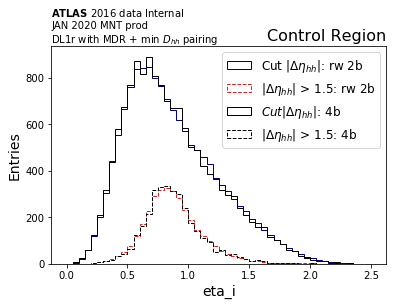

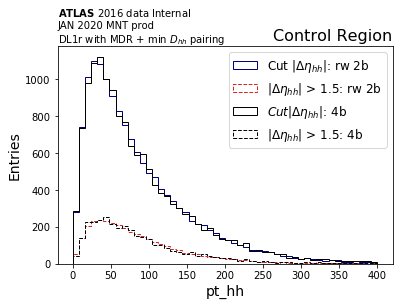

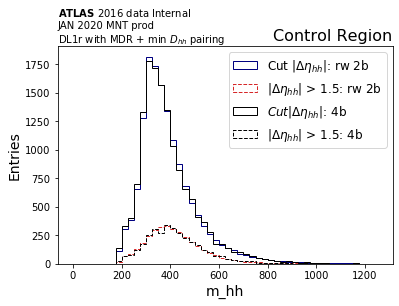

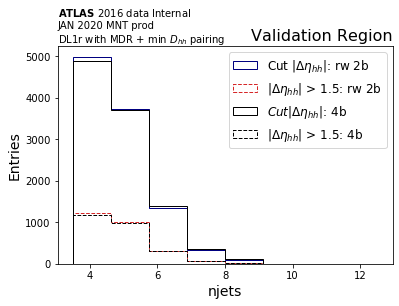

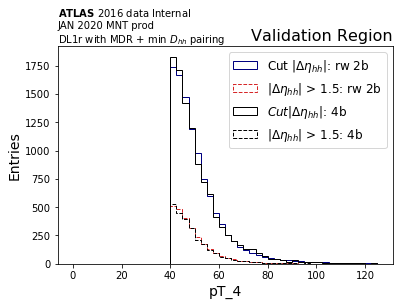

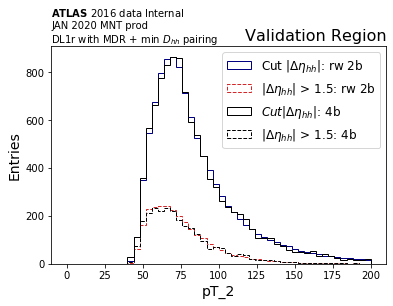

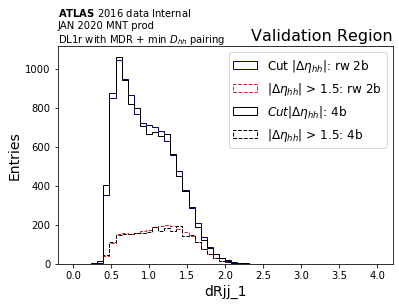

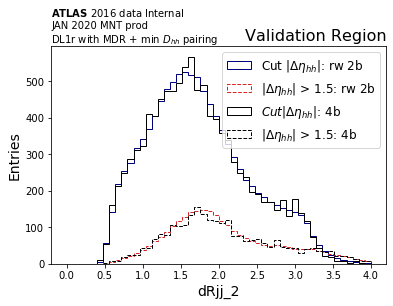

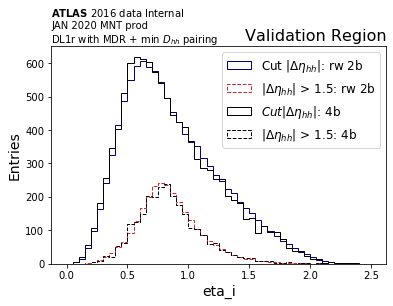

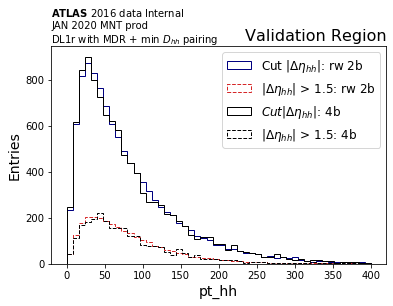

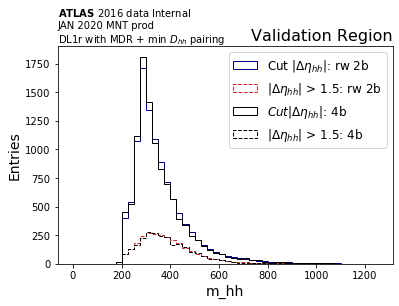

In [36]:
for region, title,tag in zip([2,1],['Control Region','Validation Region'],['CR','VR']):

    mask = (bdf.kinematic_region==region) & bdf.MDpT & bdf.cut_Xwt
    
    for c,n,r in zip(rw_vars,nBins,myRanges):

        plt.figure()
        plt.hist(bdf.loc[(bdf.ntag==2) & mask & bdf.cut_deta_hh,c], 
                 n, r, color='navy',
                 histtype='step',label='Cut $|\Delta \eta_{hh}|$: rw 2b',
                 weights=bdf.loc[(bdf.ntag==2) & mask & bdf.cut_deta_hh,'w_2b_no_deta'])
        plt.hist(bdf.loc[(bdf.ntag==2) & mask & (~bdf.cut_deta_hh),c], 
                 n, r, color='C3',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: rw 2b',
                 weights=bdf.loc[(bdf.ntag==2) & mask & (~bdf.cut_deta_hh),'w_2b_no_deta'])    

        plt.hist(bdf.loc[(bdf.ntag>=4) & mask & bdf.cut_deta_hh,c],
                 n,r,color='k',
                 histtype='step',label='$Cut |\Delta \eta_{hh}|$: 4b')
        plt.hist(bdf.loc[(bdf.ntag>=4) & mask & (~bdf.cut_deta_hh),c],
                 n,r,color='k',linestyle='--',
                 histtype='step',label='$|\Delta \eta_{hh}|$ > 1.5: 4b')

        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12)
        plt.title(title,loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

        plt.savefig(f'figures/dl1r_77/rw_figs/{c}_cf_deta_hh_cut_{tag}.pdf',bbox_inches='tight')
        plt.show()



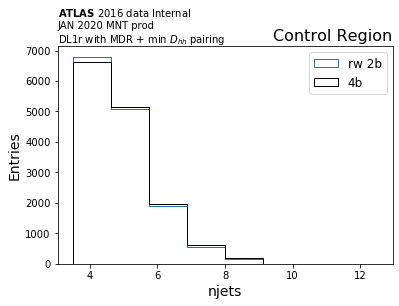

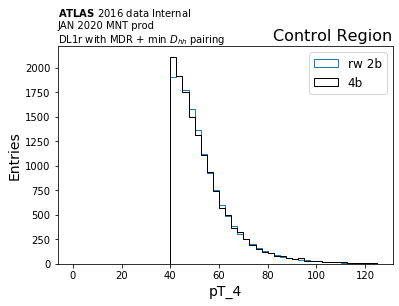

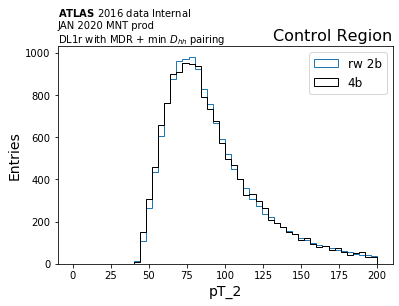

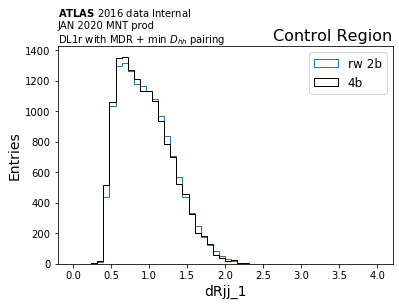

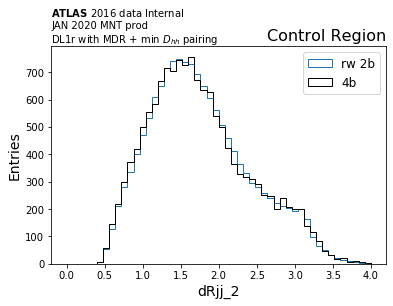

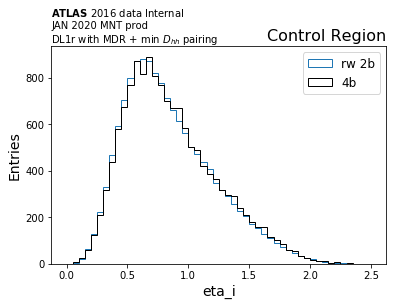

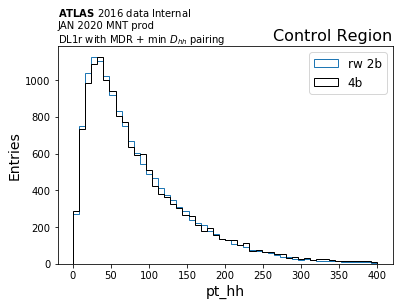

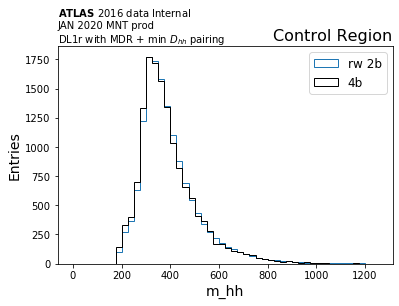

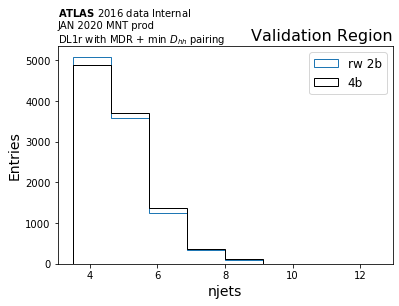

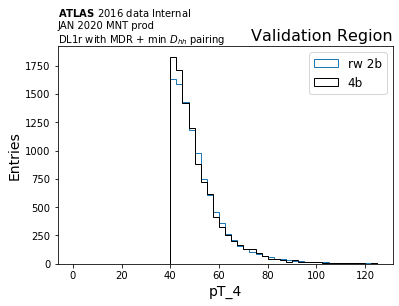

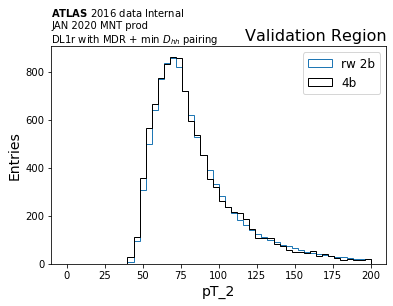

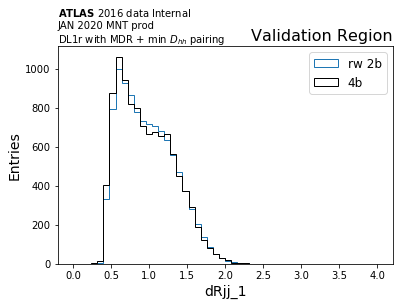

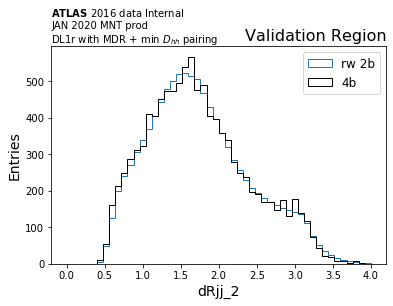

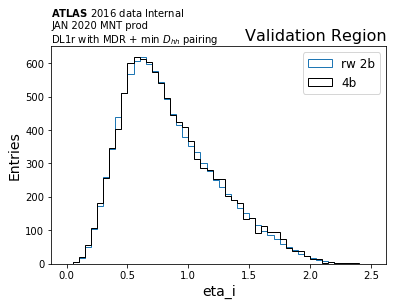

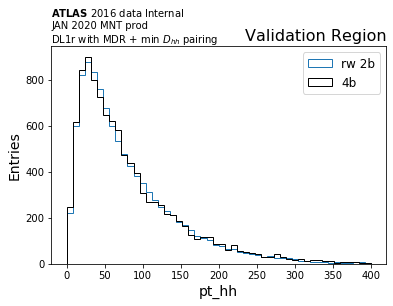

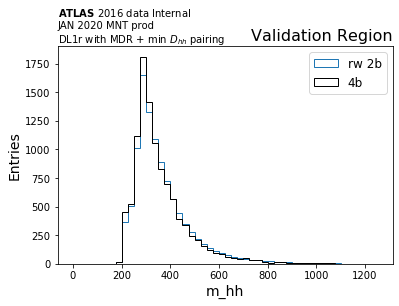

In [45]:
for region, title,tag in zip([2,1],['Control Region','Validation Region'],['CR','VR']):

    mask = (bdf.kinematic_region==region) & bdf.MDpT & bdf.cut_deta_hh & bdf.cut_Xwt
    
    for c,n,r in zip(rw_vars,nBins,myRanges):

        plt.figure()
        plt.hist(bdf.loc[(bdf.ntag==2) & mask,c], 
                 n, r, color='C0',
                 histtype='step',label='rw 2b',
                 weights=bdf.loc[(bdf.ntag==2) & mask & bdf.cut_deta_hh,'w_2b_baseline'])

        plt.hist(bdf.loc[(bdf.ntag>=4) & mask,c],
                 n,r,color='k',
                 histtype='step',label='4b')

        plt.xlabel(c,fontsize=14)
        plt.ylabel('Entries',fontsize=14)
        plt.legend(fontsize=12)
        plt.title(title,loc='right',fontsize=16)

        ax = plt.gca()
        plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

        plt.savefig(f'figures/dl1r_77/rw_figs/{c}_baseline_{tag}.pdf',bbox_inches='tight')
        plt.show()


Ok, the first message that I'm getting from these plots is that the reweighting that I derived w/ the cut is applicable when we loosen the cut as well.

*I should make these plots ratios w/ error bars!!*

But I guess I can handle that later.


**Step 2:** What can I can in terms of significance with this background estimate?

In [37]:
from plotting import plot2dSig

../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


6.9505514617888435 12358.3729036476


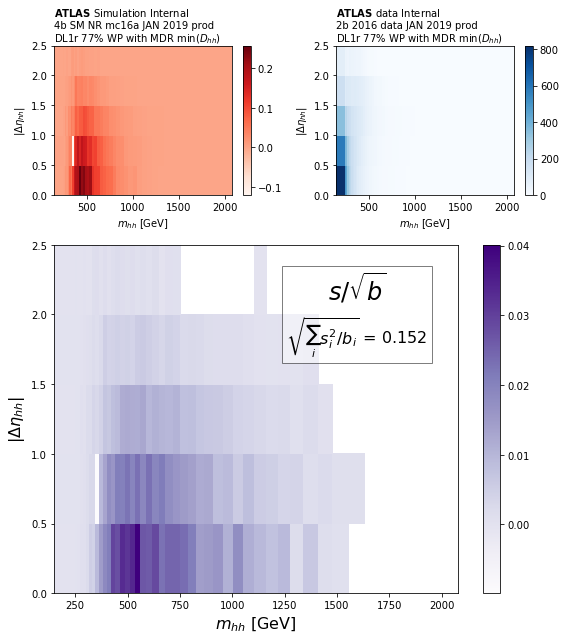

In [38]:
nBins=[edges, np.linspace(0,2.5,6)]

# But I think we want to calculate the significance *after* Xwt
significance = plot2dSig(sdf[(sdf.ntag>=4) & sdf.MDpT & sdf.cut_Xwt & (sdf.kinematic_region==0)],
                         bdf[(bdf.ntag==2) & bdf.MDpT & bdf.cut_Xwt & (bdf.kinematic_region==0)],
                         'm_hh','deta_hh',nBins,histRange=None,w2b='w_2b_no_deta',
                         smText=smText,dataText=dataText,
                         figDir='figures/dl1r_77',tag='_deta_hh_2.5_5bins')

../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)


6.332022437824165 9040.786235046573


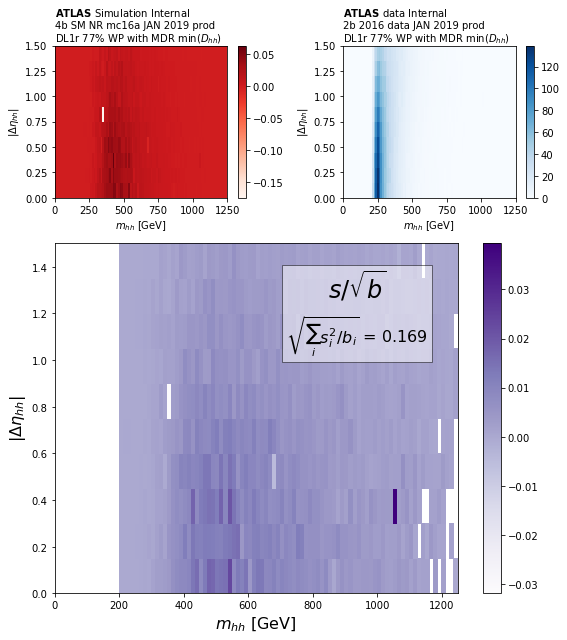

In [39]:
nBins=[100,10]
histRange = [[0,1250],[0,1.5]]

# But I think we want to calculate the significance *after* Xwt
significance  = plot2dSig(sdf[(sdf.ntag>=4)&sdf.MDpT&(sdf.X_wt>1.5)&(sdf.kinematic_region==0)],
                          bdf[(bdf.ntag==2)&bdf.MDpT&(bdf.X_wt>1.5)&(bdf.kinematic_region==0)],
                          'm_hh','deta_hh',nBins,histRange,w2b='w_2b_afterPairing',
                          smText=smText,dataText=dataText)#,
                          #figDir=f'figures/{sigSubDir}')

Maybe I should look into optimizing the bin edges here?
It doesn't seem like we're gaining *a lot* (if anything) by loosening the cut from 1.5 to 2.5.

*But with the looser WP, this is **even more** than a 10% improvement!!!*


I should calculate a limit now!

### Calculate the helicity angles


To do this, I'll need to make 4-vectors for the HCs and jets in the event - ok, in theory, I can handle this.


In [40]:
from AnalysisUtils import getHelicityAnglesRR

In [41]:
for df,tag in zip([sdf, bdf],['signal', 'background']):
    print(f'Getting helicity angles for {tag}')
    getHelicityAnglesRR(df)

Getting helicity angles for signal
Getting helicity angles for background


In [42]:
sig_mask = (sdf.ntag>=4) & sdf.MDpT & sdf.cut_deta_hh & (sdf.cut_Xwt)
bkg_mask = (bdf.ntag==2) & bdf.MDpT & bdf.cut_deta_hh & (bdf.cut_Xwt)

for col,xlabel in zip(['cosThetaStar','cosTheta1','cosTheta2','Phi','Phi1'],
                      ['$|\cos \Theta*|$','$|\cos \Theta_1|$','$|\cos \Theta_2|$','$|\Phi|$','$\Phi_1$']):
    
    for ms,mb,title,tag in zip([sdf.ntag>=4, sig_mask, sig_mask&(sdf.kinematic_region==0)],
                               [bdf.ntag==2, bkg_mask, bkg_mask&(bdf.kinematic_region==0)],
                               ['After pairing','after $X_{wt}$ cut','SR'],
                               ['','_cut_deta_hh','_SR']):
            
        dfi = pd.DataFrame(np.vstack((bdf.loc[mb,col],bdf.loc[mb,w2b])).T, 
                           columns=[col,w2b])
    
        plotSigBkg(sdf[ms], dfi,
                   col=col,nBins=50,xlabel=xlabel,
                   text=text,title=title,figDir='')

KeyError: 'w_2b'

Ok - these are *very* nice plots to have!
- $|\cos \Theta^*|$ and $|\Delta \eta_{HH}|$ are not as correlated for the baseline pairing algorithm as they are for pairAGraph.
- $\cos \theta_1$ and $\cos \theta_2$ aren't offering *any* discrimination power
- Cutting $|\Phi|$ > 1.5 might be a reasonable thing to try?
- $\Phi_1$ has no discrimination power.

But - it's worthwhile to *also* check the reweighted distributions, at this stage the interesting kinematics might not be completely captured by 2b anymore!


In [ ]:
bdf.columns

In [ ]:
for col,xlabel in zip(['cosThetaStar','cosTheta1','cosTheta2','Phi','Phi1'],
                      ['$|\cos \Theta*|$','$|\cos \Theta_1|$','$|\cos \Theta_2|$','$\Phi$','$\Phi_1$']):
    
    for ms,mb,title,tag,w2b in zip([sdf.ntag>=4, sig_mask, sig_mask&(sdf.kinematic_region==0)],
                                   [bdf.ntag==2, bkg_mask, bkg_mask&(bdf.kinematic_region==0)],
                                   ['After pairing','after $X_{wt}$ cut','SR'],
                                   ['_afterPairing','_Xwt_cut','_SR'],
                                   ['w_2b_afterPairing','w_2b_no_deta','w_2b_baseline']):
        
        dfi = pd.DataFrame(np.vstack((bdf.loc[mb,col],bdf.loc[mb,w2b])).T, 
                           columns=[col,w2b])
        
        plotSigBkg(sdf[ms], dfi, col=col, w2b=w2b, nBins=50,
                   xlabel=xlabel, bkg_c='C9', bkg_label='rw 2b 2016 data',
                   text=text, title=title, figDir='figures/dl1r_77',tag=tag)

**Thoughts**
- $|\cos \Theta^*|$ is still *by far* the most discriminating variable.
- The reweighting is acutally making $\cos \Theta_1$ and $\cos \Theta_2$ seem slightly more promising for discrimination, i.e, we might consider cuts $|\cos \Theta_1| < 0.7$ and $|\cos \Theta_2| < 0.7$, but this won't take out a lot of background. It's also not clear how these large $\cos \Theta_i$ are correlated with $m_{hh}$ atm, this could just be the low $m_{hh}$ events that are easy to eliminate another way.
- A $\Phi$ > .7 cut still seems promising!

**Let's overlay the $|\cos \Theta^*|$ curves with and without the $\Delta \eta_{hh}$ cut**

Maybe I can put signal and background on the same plot and have two different y-axes?

In [ ]:
col = 'cosThetaStar'
nBins = 25
histRange=(0,1)
sig_c,bkg_c = 'C4','k'
bkg_label='rw 2b'

plt.hist(np.abs(bdf.loc[(bdf.ntag==2)&bdf.MDpT&(bdf.X_wt>1.5)&(bdf.kinematic_region==0),col]),
         nBins,histRange,label='rw 2b: no $|\Delta \eta_{hh}|$ cut',color=bkg_c,histtype='step',
         weights=bdf.loc[(bdf.ntag==2)&bdf.MDpT&(bdf.X_wt>1.5)&(bdf.kinematic_region==0),'w_2b_no_deta'])
plt.hist(np.abs(bdf.loc[bkg_mask&(bdf.kinematic_region==0),col]),
         nBins,histRange,label='rw 2b: $|\Delta \eta_{hh}|$ < 1.5',color=bkg_c,histtype='step',linestyle='--',
         weights=bdf.loc[bkg_mask&(bdf.kinematic_region==0),'w_2b_baseline'])

ax1 = plt.gca()
ax2 = ax1.twinx()

ax2.hist(np.abs(sdf.loc[(sdf.ntag>=4)&sdf.MDpT&(sdf.X_wt>1.5)&(sdf.kinematic_region==0),col]),
         nBins,label='4b SM: no $|\Delta \eta_{hh}|$ cut',color=sig_c,histtype='step',
         weights=sdf.loc[(sdf.ntag>=4)&sdf.MDpT&(sdf.X_wt>1.5)&(sdf.kinematic_region==0),'mc_sf'])
ax2.hist(np.abs(sdf.loc[sig_mask&(sdf.kinematic_region==0),col]),
         nBins,histRange,label='4b SM: $|\Delta \eta_{hh}|$ < 1.5',color=sig_c,histtype='step',linestyle='--',
         weights=sdf.loc[sig_mask&(sdf.kinematic_region==0),'mc_sf'])


ax1.set_xlabel('$|\cos \Theta*|$',fontsize=14)
ax1.set_ylabel('Background entries',fontsize=14)
ax2.set_ylabel('Signal entries',fontsize=14)

ax2.tick_params(axis='y', colors=sig_c)
ax2.yaxis.label.set_color(sig_c)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes)
plt.title(title,loc='right',fontsize=16)

ax1.legend(loc='lower left')
ax2.legend(loc='center left',bbox_to_anchor=(0,.325))

ax1.set_xlim(0,1)

plt.savefig(f'figures/dl1r_77/rw_figs/cosThetaStar_cf_deta_cut_SR.pdf',bbox_inches='tight')

plt.show()


Ok, let's look at the 2d significance!

../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


6.9552208420792 12520.615259733051


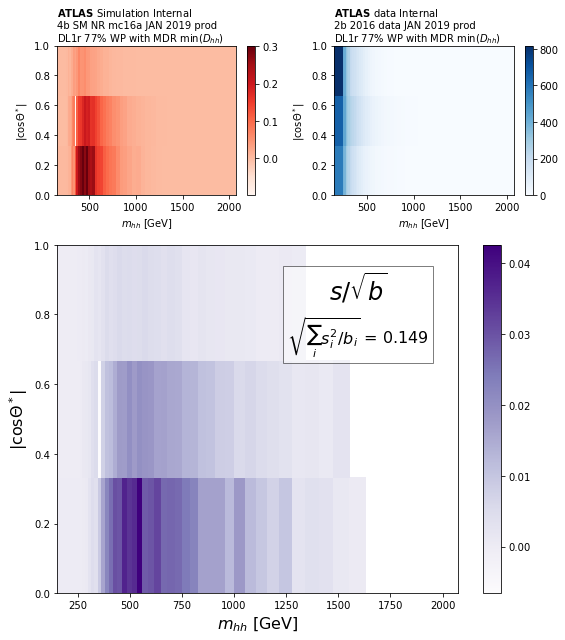

In [46]:
# nBins=[100,5]
# histRange = [[0,1250],[0,1]]

nBins=[edges,np.linspace(0,1,4)]

# But I think we want to calculate the significance *after* Xwt
significance  = plot2dSig(sdf[(sdf.ntag>=4)&sdf.MDpT&(sdf.X_wt>1.5)&(sdf.kinematic_region==0)],
                          bdf[(bdf.ntag==2)&bdf.MDpT&(bdf.X_wt>1.5)&(bdf.kinematic_region==0)],
                          'm_hh','cosThetaStar',nBins,histRange,w2b='w_2b_no_deta',
                          smText=smText,dataText=dataText,ylabel='$|\cos \Theta^*|$')#,
                          #figDir=f'figures/{sigSubDir}')

In [ ]:
# But I think we want to calculate the significance *after* Xwt
significance  = plot2dSig(sdf[sig_mask&(sdf.kinematic_region==0)],
                          bdf[bkg_mask&(bdf.kinematic_region==0)],
                          'm_hh','cosThetaStar',nBins,histRange,w2b='w_2b_baseline',
                          smText=smText,dataText=dataText,ylabel='$|\cos \Theta^*|$')#,
                          #figDir=f'figures/{sigSubDir}')

In [48]:
edges

array([ 150,  250,  262,  275,  288,  302,  317,  332,  348,  365,  383,
        402,  422,  443,  465,  488,  512,  537,  563,  591,  620,  651,
        683,  717,  752,  789,  828,  869,  912,  957, 1004, 1054, 1106,
       1161, 1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884,
       1978, 2076])

**Let's play with non-uniform bins**

Running w/ conda env: don't import root packages.


../code/plotting.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1132: RuntimeWarning: invalid value encountered in true_divide
  sig = s/np.sqrt(b)
../code/plotting.py:1160: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


6.33796532087625 9618.183751154342


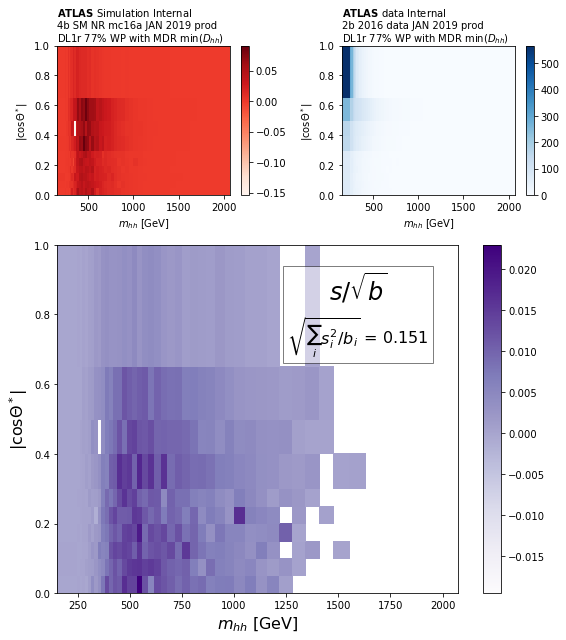

In [55]:
# But I think we want to calculate the significance *after* Xwt

cos_edges = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.65, 1])
nBins=[edges,cos_edges]

s,b  = plot2dSig(sdf[sig_mask&(sdf.kinematic_region==0)],
                          bdf[bkg_mask&(bdf.kinematic_region==0)],
                          'm_hh','cosThetaStar',nBins,None,w2b='w_2b_baseline',
                          smText=smText,dataText=dataText,ylabel='$|\cos \Theta^*|$',
                          figDir='figures/dl1r_77',tag='_varBins')

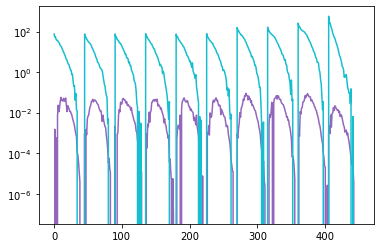

In [59]:
plt.semilogy(s.T.reshape(-1,1),color='C4')
plt.semilogy(b.T.reshape(-1,1),color='C9')

In [65]:
list(s.T.reshape(-1))

[0.0,
 0.0015291675264710114,
 0.0,
 0.0005761194183212551,
 0.0,
 0.007102406803761307,
 0.023386848000128947,
 0.011218899694499365,
 0.01728037177067179,
 0.03524462426016866,
 0.05723418737442606,
 0.03993934203565843,
 0.04390266233609931,
 0.03713982353615698,
 0.05146465727141707,
 0.0397036038367656,
 0.03641437573114903,
 0.05317313047326114,
 0.025369440449059765,
 0.011387165576994391,
 0.02241185812314783,
 0.01856054392020276,
 0.01616762101269755,
 0.011497960598819704,
 0.011696877958786558,
 0.009449346452421233,
 0.00802902305750834,
 0.005633837421872525,
 0.004197180655052541,
 0.003215814332360251,
 0.0023229823451688665,
 0.0013748120661763862,
 0.000932858159855072,
 0.0006519901232156238,
 0.00011056213748700375,
 8.230236041917274e-05,
 3.528038055564722e-05,
 1.26614208743268e-05,
 3.82432645744312e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0009145293718843753,
 0.0,
 0.001493817383970279,
 0.0008305098598043934,
 0.004960945868938941,
 0.006873393141460356,
 

In [66]:
band = getExpectedBand(list(s.T.reshape(-1)),
                       list(b.T.reshape(-1)),
                       mu_tests)
stats.loc[bidx,'$cos \Theta^*$ categorization'] = band

In [68]:
stats.columns

Index(['MDR+min($D_{hh}$)', 'BDT pairing', '$cos \Theta^*$ categorization'], dtype='object')

In [69]:
stats[['BDT pairing', 'MDR+min($D_{hh}$)', '$cos \Theta^*$ categorization']]

BDT pairing  MDR+min($D_{hh}$)  $cos \Theta^*$ categorization
$-2\sigma$     8.332081           8.024449                       7.017348
$-\sigma$     11.186766          10.825654                       9.525941
exp           15.598835          15.074463                      13.306614
$+\sigma$     21.817966          21.114851                      18.700292
$+2\sigma$    29.475031          28.544301                      25.359139

In [71]:
13.3/15.07

0.8825481088254811

In [72]:
13.3/15.59

0.8531109685695959

In [ ]:
nBins=[100,5]
histRange = [[0,1250],[0,1]]

# But I think we want to calculate the significance *after* Xwt
significance  = plot2dSig(sdf[(sdf.ntag>=4)&sdf.MDpT&(sdf.X_wt>1.5)&(sdf.kinematic_region==0)],
                          bdf[(bdf.ntag==2)&bdf.MDpT&(bdf.X_wt>1.5)&(bdf.kinematic_region==0)],
                          'm_hh','cosThetaStar',nBins,histRange,w2b='w_2b_afterPairing',
                          smText=smText,dataText=dataText,ylabel='$|\cos \Theta^*|$')#,
                          #figDir=f'figures/{sigSubDir}')

In [ ]:
np.min(sdf.deta_hh)

In [ ]:
nBins=[100,5]
histRange = [[0,1250],[0,1]]

# But I think we want to calculate the significance *after* Xwt
significance  = plot2dSig(sdf[sig_mask&(sdf.kinematic_region==0)],
                          bdf[bkg_mask&(bdf.kinematic_region==0)],
                          'm_hh','cosThetaStar',nBins,histRange,w2b='w_2b_afterPairing',
                          smText=smText,dataText=dataText,ylabel='$|\cos \Theta^*|$')#,
                          #figDir=f'figures/{sigSubDir}')

Ok, so I think after I've marched through this nb, this is a big step in terms of having my questions answered!

I'd still like to explore what signal we can gain by loosening the $p_T$ cut as well, and how the increasing background at the lower jet $p_T$ interplays with our cut values. 